<h1><center>Final Project: Pneumonia Detection by Image Classification using Convolutional Neural Networks</center></h1>
    <h2><center>Gareth Hughes</center></h2>
    <h3><center>Data Analytics March 2020</h3></center>


#### This notebook describes the series of steps I took in order to train a convolutional neural network to try to detect the presence of Pneumonia in lungs. This was achieved by looking at computerized tomography (CT) scans of lungs of patients whole have normal lungs and those suffering from pneumonia. In order to better train the model, all images utilised are from an Anterior Posterior (AP) viewpoint. 

#### The use of machine learning to assist doctors and radiologists in determining the presence of pneumonia would be beneficial in reducing mis-diagnosis, reducing work loads and potentially providing a second opinion.

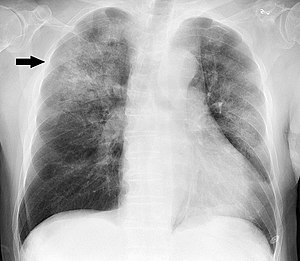

#### Pneumonia is characterised as inflammation of the lungs which affects the alveoli. Pneumonia can be caused by viruses (COVID-19), bacteria, medications or autoimmune diseases.

In [117]:
# Here I import the libraries that I need to use in the project.
from IPython.display import Image
from IPython.core.display import HTML 
from collections import Counter

import cv2
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt #for plotting things
import os
import os.path
import shutil
import seaborn as sns
import joblib

# Keras Libraries utilised for the CNN.
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import model_from_json
from tensorflow.keras.models import load_model
from keras.utils import plot_model

#### This function below is used to reset the CNN model incase I want to retrain it from scratch.

In [101]:
keras.backend.clear_session()

#### Here are the absolute paths to the training, validation and test images that are available in the dataset. 

In [22]:
train_images = r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train"
val_images = r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val"
test_images = r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test"

#### This function serves to feed in the from the train, validation and test image datasets, label them appropiately as a 0 or a 1 based on their location (either in the Pneumonia or Normal files). Then, it iterates through the images, converts them to grayscale, resizes the image to a smaller 128 x 128 dimension and converts it into an array of numbers. This list of pixels, along with the label (0 or 1), is then appended into the an array. 

In [23]:
labels = ['PNEUMONIA', 'NORMAL']

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        print(path)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), 
                                     cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (128, 128))
                data.append([resized_arr, class_num])
            
            except Exception as e:
                print(e)
    return np.array(data)

In [24]:
train = get_training_data(r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train")
val = get_training_data(r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val")
test = get_training_data(r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test")

C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train\PNEUMONIA
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train\NORMAL
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val\PNEUMONIA
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val\NORMAL
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test\PNEUMONIA
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test\NORMAL


#### Here's the distribution of our images per set.

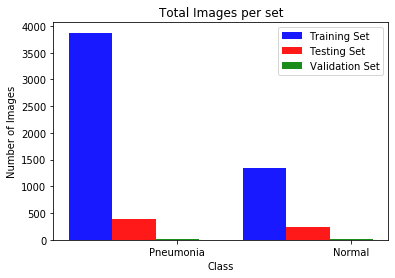

In [36]:
train_cases = pd.DataFrame(train)
test_cases = pd.DataFrame(test)
val_cases = pd.DataFrame(val)

train_cases = train_cases[1].value_counts()
test_cases = test_cases[1].value_counts()
val_cases = val_cases[1].value_counts()

labels = ['PNEUMONIA', 'NORMAL']

index = np.arange(len(labels))
bar_width = 0.25
opacity = 0.9

fig, ax = plt.subplots()

train_bar = ax.bar(index - bar_width, train_cases, bar_width,
                alpha=opacity, color='b',
                label='Training Set')

test_bar = ax.bar(index, test_cases, bar_width,
                alpha=opacity, color='r', tick_label = ('Pneumonia', 'Normal'),
                label='Testing Set')
val_bar = ax.bar(index + bar_width, val_cases, bar_width,
                  alpha=opacity, color='g', tick_label = ('Pneumonia', 'Normal'),
                label='Validation Set')


plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Total Images per set')
plt.xticks(index + bar_width)
plt.legend()
plt.show()

In [37]:
def percentage(image_set):
    for l, i in zip(labels, list(image_set)):
        num = (int(i) / sum(list(image_set)))
        print(l,' images make up ',round(num * 100),'% of the set')

In [38]:
percentage(train_cases)

PNEUMONIA  images make up  74 % of the set
NORMAL  images make up  26 % of the set


In [39]:
percentage(test_cases)

PNEUMONIA  images make up  62 % of the set
NORMAL  images make up  38 % of the set


In [40]:
percentage(val_cases)

PNEUMONIA  images make up  50 % of the set
NORMAL  images make up  50 % of the set


#### As you can see, the dataset provided is quite unbalanced, in order to combat this problem I will use the ImageDataGenerator model which I will describe later.

#### Below, you can see that the images are stored within the training dataset and with the appropiate label.

Text(0.5, 1.0, 'NORMAL')

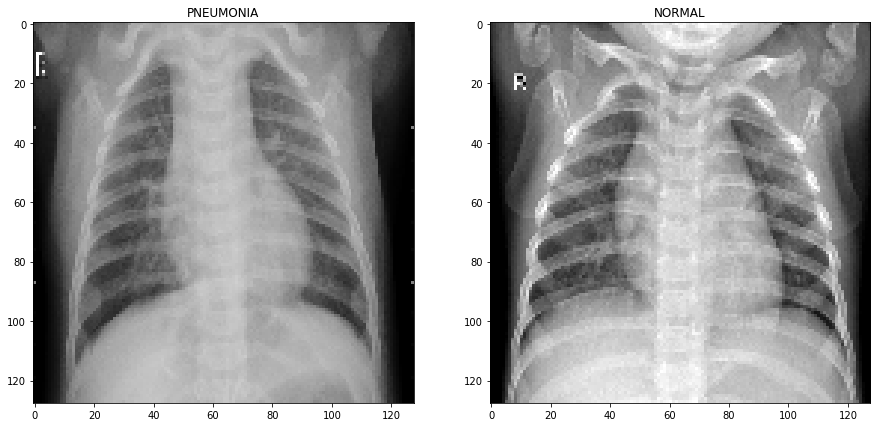

In [42]:
%matplotlib inline
f, ax = plt.subplots(1, 2, figsize = (15,15))
ax[0].imshow(train[1][0], cmap = 'gray')
ax[0].set_title(labels[train[1][1]])
ax[1].imshow(train[5000][0], cmap = 'gray')
ax[1].set_title(labels[train[5000][1]])

## Preparing the image data for implementation into our CNN.

#### Here, I extract the feature (the numpy array per image), and the label (the class of the image), and append the data into x and y sets.  

In [53]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [54]:
x_train[0]

array([[19, 27, 30, ..., 16,  9,  2],
       [24, 26, 34, ..., 17, 11,  4],
       [22, 30, 39, ..., 19, 11,  4],
       ...,
       [10,  8,  7, ..., 15, 15, 15],
       [10,  8,  7, ..., 15, 15, 15],
       [10, 10,  7, ..., 15, 15, 15]], dtype=uint8)

In [55]:
len(x_train)

5216

### Reducing the Colour Data Down to Grayscale (0 - 1) instead of (0 - 255)

#### This significantly reduces the amount of information that the neural network needs to process, thereby reducing the amount of data that's needed to be allocated to memory and reducing the computation time.

In [57]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [58]:
x_train[0]

array([[0.0745098 , 0.10588235, 0.11764706, ..., 0.0627451 , 0.03529412,
        0.00784314],
       [0.09411765, 0.10196078, 0.13333333, ..., 0.06666667, 0.04313725,
        0.01568627],
       [0.08627451, 0.11764706, 0.15294118, ..., 0.0745098 , 0.04313725,
        0.01568627],
       ...,
       [0.03921569, 0.03137255, 0.02745098, ..., 0.05882353, 0.05882353,
        0.05882353],
       [0.03921569, 0.03137255, 0.02745098, ..., 0.05882353, 0.05882353,
        0.05882353],
       [0.03921569, 0.03921569, 0.02745098, ..., 0.05882353, 0.05882353,
        0.05882353]])

In [59]:
x_train.shape

(5216, 128, 128)

#### Here I reshape the data into a 4D array. This is because the image is composed of height, width, number of channels and the number of images.

In [48]:
img_size = 128

In [82]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [83]:
print(x_train.shape)

(5216, 128, 128, 1)


### ImageDataGenerator

#### This parameter can be used to generate more data from our dataset by feeding in images and manipulating them by flipping their horizontal axis or rotating them. This serves as a way to artificially increase the size of our dataset. This is applied to both the Training Data and Validation Data.

In [97]:
datagen = ImageDataGenerator(horizontal_flip = True,
                             rotation_range = 5,
                            zoom_range = 0.1,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,)

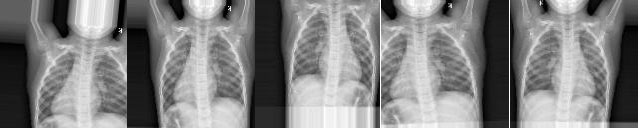

## CNN Model

In [98]:
Image(url = 'https://miro.medium.com/max/2510/1*XbuW8WuRrAY5pC4t-9DZAQ.jpeg')

In [126]:
cnn3 = Sequential()

#Convolution - "Relu" is the activation function.
cnn3.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 1)))

#Pooling - This reduces the spatial dimensions of the output volume.
cnn3.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution - This increases the number of filters to improve filtering
cnn3.add(Conv2D(64, (3, 3), activation="relu"))

# 2nd Pooling layer
cnn3.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer - converts the pooled layer into a 1D vector. 
cnn3.add(Flatten())

# Density
cnn3.add(Dense(activation = 'relu', units = 2048, kernel_initializer = 'uniform'))
cnn3.add(Dense(activation = 'relu', units = 1024, kernel_initializer = 'uniform'))
cnn3.add(Dense(activation = 'relu', units = 512, kernel_initializer = 'uniform'))
cnn3.add(Dense(activation = 'relu', units = 265, kernel_initializer = 'uniform'))
cnn3.add(Dense(activation = 'sigmoid', units = 1, kernel_initializer = 'uniform'))

# Compile 
cnn3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [127]:
cnn3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              117966848 
_________________________________________________________________
dense_7 (Dense)              (None, 1024)             

In [128]:
history = cnn3.fit(datagen.flow(x_train, y_train, batch_size = 50), epochs = 15,
                                  validation_data = datagen.flow(x_val, y_val))

Epoch 1/15
105/105 [==============================] - 155s 1s/step - loss: 0.5359 - accuracy: 0.7502 - val_loss: 0.6433 - val_accuracy: 0.6875
Epoch 2/15
105/105 [==============================] - 153s 1s/step - loss: 0.3215 - accuracy: 0.8608 - val_loss: 0.5750 - val_accuracy: 0.8125
Epoch 3/15
105/105 [==============================] - 152s 1s/step - loss: 0.2429 - accuracy: 0.8959 - val_loss: 1.2471 - val_accuracy: 0.6875
Epoch 4/15
105/105 [==============================] - 164s 2s/step - loss: 0.2341 - accuracy: 0.9078 - val_loss: 1.0961 - val_accuracy: 0.5000
Epoch 5/15
105/105 [==============================] - 162s 2s/step - loss: 0.2147 - accuracy: 0.9089 - val_loss: 1.6841 - val_accuracy: 0.5625
Epoch 6/15
105/105 [==============================] - 163s 2s/step - loss: 0.1880 - accuracy: 0.9266 - val_loss: 1.5391 - val_accuracy: 0.6875
Epoch 7/15
105/105 [==============================] - 159s 2s/step - loss: 0.1888 - accuracy: 0.9218 - val_loss: 1.1152 - val_accuracy: 0.7500

In [129]:
print("Loss of the model is - " , cnn3.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , cnn3.evaluate(x_test,y_test)[1]*100 , "%")

624/624 [==============================] - 3s 4ms/step
Loss of the model is -  45.2481310790739 %
624/624 [==============================] - 3s 4ms/step
Accuracy of the model is -  85.41666865348816 %


In [130]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.9447853
validation_accuracy 0.75


In [131]:
predictions = cnn3.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [132]:
correct_class = []
incorrect_class = []
correct = []
incorrect = []

for i, y in (zip(predictions, y_test)):
    
    if i == y:
        correct.append(1)
        correct_class.append(i)
    
    elif i != y:
        incorrect.append(1)
        incorrect_class.append(y)
        
print('Number of correct predictions:', sum(correct))
print('Number of incorrect predictions:', sum(incorrect))

Number of correct predictions: 533
Number of incorrect predictions: 91


In [133]:
corr = Counter(correct_class)
incorr = Counter(incorrect_class)
corr = list(corr.values())
incorr = list(incorr.values())
print('Number of Pneumonia Cases correctly guessed:', corr[0])
print('Number of Normal Cases correctly guessed:', corr[1])
print('Number of Pneumonia Cases incorrectly guessed:', incorr[0])
print('Number of Normal Cases incorrectly guessed:', incorr[1])

Number of Pneumonia Cases correctly guessed: 381
Number of Normal Cases correctly guessed: 152
Number of Pneumonia Cases incorrectly guessed: 9
Number of Normal Cases incorrectly guessed: 82


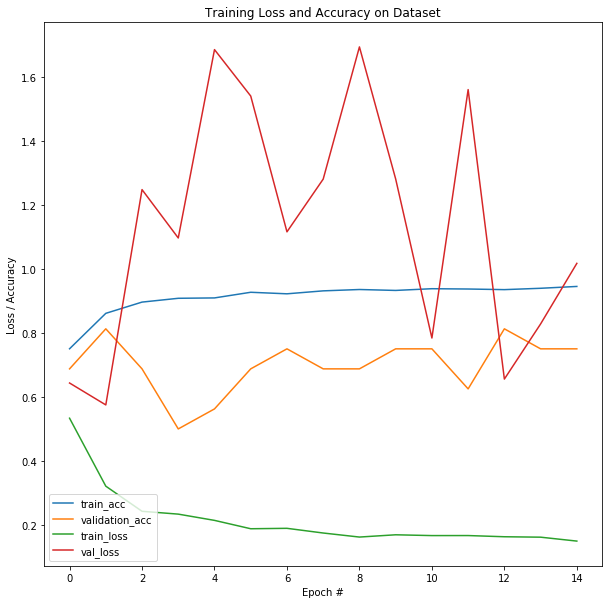

In [134]:
plt.figure(figsize = (10,10))
plt.plot(history.history['accuracy'], label = "train_acc")
plt.plot(history.history['val_accuracy'], label = "validation_acc")
plt.plot(history.history['loss'], label = "train_loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.title('Training Loss and Accuracy on Dataset')
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='lower left')
plt.show()

In [135]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.82      0.98      0.89       390
   Normal (Class 1)       0.94      0.65      0.77       234

           accuracy                           0.85       624
          macro avg       0.88      0.81      0.83       624
       weighted avg       0.87      0.85      0.85       624



In [136]:
cm = confusion_matrix(y_test,predictions)
cm

array([[381,   9],
       [ 82, 152]], dtype=int64)

In [137]:
cm_df = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

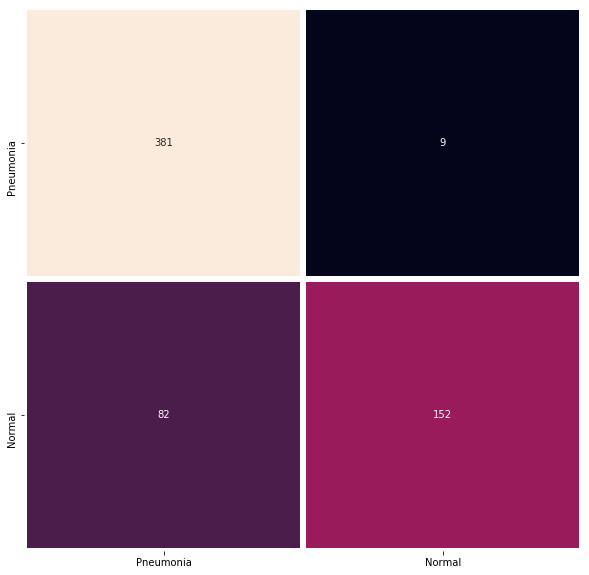

In [138]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_df, linewidth = 5 , annot = True, fmt='d',
           xticklabels = ['Pneumonia', 'Normal'],
           yticklabels = ['Pneumonia', 'Normal'],
           cbar = False)

In [139]:
cnn3.save('cnn3_model_attempt5_normalimages_FINAL 20.05.2020.model')
cnn3.save_weights('cnn3_model_attempt5_normalimages_weights_FINAL 20.05.2020.h5')